In [1]:
from testproblems import generate_random_prob, random_problem_with_artifacts
from representations import bipartite_repr
from inputresolver import resolve,invert_edges,getallvars,direct_eqs
from datastructures.polycasebuilder import eqv_to_edges_tree
from datastructures.graphutils import flat_graph_formulation, draw_graph_graphical_props, VAR, COMP, SOLVER, Node, namefromid
from datastructures.operators import sort_scc
#from networkx.algorithms.bipartite import random_graph as bipartite_random_graph

In [2]:
from datastructures.tearing import min_arc_set, dir_graph
from datastructures.rendering import render_incidence
from datastructures.graphutils import all_edges, edges_to_Ein_Eout
from collections import OrderedDict
import matplotlib.pyplot as plt

In [3]:
import networkx as nx

In [4]:
import gurobipy as gp
from gurobipy import GRB

# Parameters

In [5]:
m = 50
n = 55
seed = 10#8 is triang#seed 10 is nice 42
sparsity = 1.5#0.87#0.8 1.1 #1.7 1.3

In [6]:
kwargs = random_problem_with_artifacts(m,n,seed,sparsity)

In [7]:
edges_varonleft = kwargs["edges_varonleft"]
outset = kwargs["outset"]
varidxs = kwargs["varidxs"]
eqnidxs = kwargs["eqnidxs"]

In [8]:
cycles, elimset, m = min_arc_set(edges_varonleft, outset, varidxs, eqnidxs)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [9]:
elimset

{3, 7, 12, 14, 20, 25, 32, 36, 40, 41}

In [9]:
elimset

{7, 12, 14, 20, 25, 27, 31, 32, 36, 40}

# Setup

In [96]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}

# Original indexation

In [97]:
eqv, varinc, output_idx = generate_random_prob(n_eqs, n_vars, seed, sparsity)
_, edges_original = bipartite_repr(eqv)
eqs = direct_eqs(eqv, output_idx)
varidxs = getallvars(eqs, sympy=False)
eqnidxs = set(eqs.keys())

In [98]:
sum([len(var) for key,var in eqv.items()])/100

0.39

In [99]:
output_reidx = {key:var-n_eqs for key,var in output_idx.items()}
edges, tree = eqv_to_edges_tree(eqv, output_reidx, n_eqs)

In [100]:
#all_edges(*edges_to_Ein_Eout(edges))

In [10]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
maxscc = max([len(elt) for elt in merge_order])

In [44]:
merge_order

[{f_2}, {f_0, f_1, f_3, f_4, f_5, f_6, f_7, f_8, f_9}]

In [29]:
elim_edges_default = [comp.name for elt in merge_order for comp in elt if len(elt)>1]

In [49]:
G1 = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr)
elimedges1 = [(Node(int(elt),COMP,nodetyperepr), Node(output_reidx[elt], VAR,nodetyperepr)) for elt in elim_edges_default]
Ftree_default = OrderedDict([(elt.name,'solver') for comp in merge_order for elt in comp])
Einn, Eoutn, Rinn = edges
_, Stree, Vtree = tree
for comp,out in elimedges1:
    Eoutn[comp.name] = (None,) 
    Rinn[comp.name] = (out.name,)
    Vtree[out.name] = 'solver'
    Stree = {'solver':'root'}
edges_default = Einn, Eoutn, Rinn
tree_default = Ftree_default, Stree, Vtree

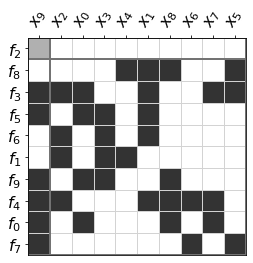

In [51]:
_, ax = render_incidence(edges_default, tree_default, namingfunc, displaysolver=True)
plt.sca(ax)
plt.savefig(r'structure_optim/original_15x15.png', dpi=300, bbox_inches='tight')

# Optimize structure

In [101]:
cycles, elimset = min_arc_set(edges_original, output_idx, varidxs, eqnidxs)

In [102]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}
G2 = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr)

In [103]:
elimedges = [(Node(int(elt),COMP,nodetyperepr), Node(output_reidx[elt], VAR,nodetyperepr)) for elt in elimset]

In [104]:
G2.remove_edges_from(elimedges)

In [105]:
min_fas_order = sort_scc(G2)

In [106]:
Ftree_mina = OrderedDict([(next(iter(comp)).name,'solver') for comp in min_fas_order])

In [107]:
Einn, Eoutn, Rinn = edges
_, Stree, Vtree = tree
for comp,out in elimedges:
    Eoutn[comp.name] = (None,) 
    Rinn[comp.name] = (out.name,)
    Vtree[out.name] = 'solver'
    Stree = {'solver':'root'}
edges_mina = Einn, Eoutn, Rinn
tree_mina = Ftree_mina, Stree, Vtree

In [108]:
namingfunc = namefromid(nodetyperepr)

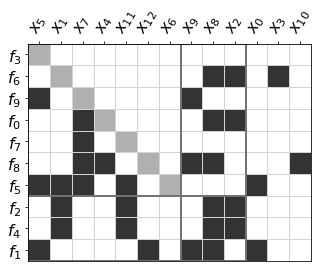

In [109]:
_, ax = render_incidence(edges_mina, tree_mina, namingfunc, displaysolver=True)
plt.sca(ax)
plt.savefig(r'structure_optim/minimum_feedback_10x13.png', dpi=300, bbox_inches='tight')

In [120]:
from itertools import combinations

# Verify

In [123]:
boolean = []
for elimset in list(combinations(eqnidxs, 6)):
    Gcopy = G.copy()
    elimedges = [(Node(int(elt),COMP,nodetyperepr), Node(output_reidx[elt], VAR,nodetyperepr)) for elt in elimset]
    Gcopy.remove_edges_from(elimedges)
    boolean.append(nx.is_directed_acyclic_graph(Gcopy))

In [126]:
sum(boolean)

5

In [52]:
for elt in eqnidxs:
    G2.copy()

OutEdgeView([(x_{0}, f_{0}), (x_{0}, f_{5}), (x_{0}, f_{9}), (f_{0}, x_{7}), (x_{8}, f_{0}), (x_{8}, f_{4}), (x_{8}, f_{8}), (x_{9}, f_{0}), (x_{9}, f_{3}), (x_{9}, f_{4}), (x_{9}, f_{5}), (x_{9}, f_{7}), (x_{9}, f_{9}), (x_{3}, f_{1}), (x_{3}, f_{5}), (x_{3}, f_{9}), (x_{4}, f_{1}), (x_{1}, f_{3}), (x_{1}, f_{4}), (x_{1}, f_{6}), (x_{1}, f_{8}), (x_{2}, f_{3}), (x_{2}, f_{4}), (x_{2}, f_{6}), (x_{5}, f_{3}), (x_{5}, f_{8}), (x_{7}, f_{3}), (x_{7}, f_{4}), (f_{4}, x_{6}), (f_{5}, x_{1}), (x_{6}, f_{7}), (f_{7}, x_{5}), (f_{8}, x_{4}), (f_{9}, x_{8}), (f_{2}, x_{9})])